In [ ]:
# Notre DIP
!git clone https://github.com/quentgar/deep_image_prior.git
!mv deep_image_prior/* ./

Cloning into 'deep_image_prior'...
remote: Enumerating objects: 1017, done.
remote: Counting objects: 100% (456/456), done.
remote: Compressing objects: 100% (228/228), done.
remote: Total 1017 (delta 215), reused 431 (delta 205), pack-reused 561
Receiving objects: 100% (1017/1017), 79.93 MiB | 25.56 MiB/s, done.
Resolving deltas: 100% (468/468), done.


In [ ]:
pip install voxelmorph

     |████████████████████████████████| 75 kB 2.0 MB/s 
     |████████████████████████████████| 86 kB 789 kB/s 


In [ ]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
#from src.hourglass_network import *
import torch
import torch.optim

from src.utils import *
from src.hourglass_network import *
from skimage.measure import compare_psnr

from voxelmorph.torch.layers import SpatialTransformer
import seaborn as sns

import cv2
from google.colab.patches import cv2_imshow

from mpl_toolkits.axes_grid1 import ImageGrid
from src.Quentin.rototranslation import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
dim_div_by = 32

In [ ]:
img1_path = 'mydata/video/car_window/12.jpg'
img2_path = 'mydata/video/car_window/13.jpg'

In [ ]:
img_np1 = format_image(img1_path, dim_div_by)
img_np2 = format_image(img2_path, dim_div_by)

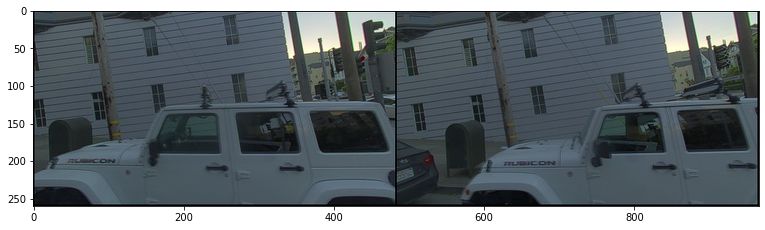

In [ ]:
plot_image_grid([img_np1, img_np2], 3,11);

In [ ]:
size = img_np1.shape[1:]

In [ ]:
INPUT = 'noise'
input_depth = 32
LR = 0.01 
num_iter = 3000
param_noise = False
show_every = 50
figsize = 5
reg_noise_std = 0.03
depth = 5

net = build_hourglass(input_depth, output_depth=2, 
            num_channels_down = [128]*depth,
            num_channels_up =   [128]*depth,
            num_channels_skip =    [16]*depth,  
            filter_size_up = 5, filter_size_down = 5,
            up_samp_mode='nearest', filter_skip_size=1,num_scales=depth,need_sigmoid=False).type(dtype)

net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_np1.shape[1:]).type(dtype)

# Spatial transformer
transformer = SpatialTransformer(size)

In [ ]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_var1 = np_to_torch(img_np1).type(dtype)
img_var2 = np_to_torch(img_np2).type(dtype)

Number of params: 7062130


Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.


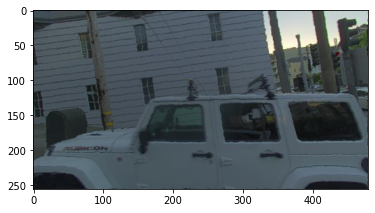

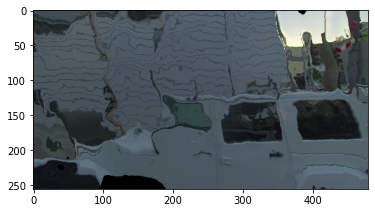

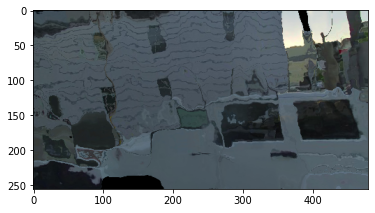

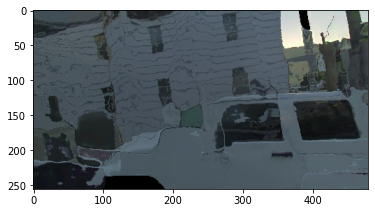

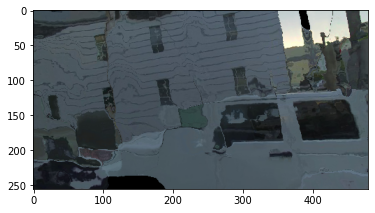

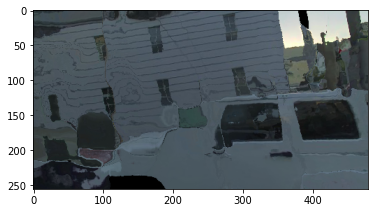

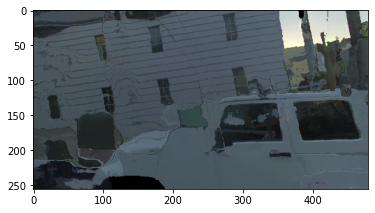

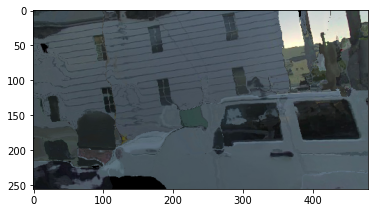

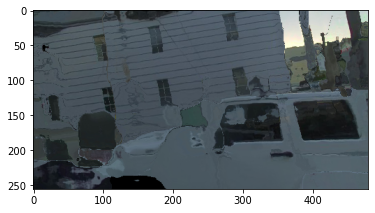

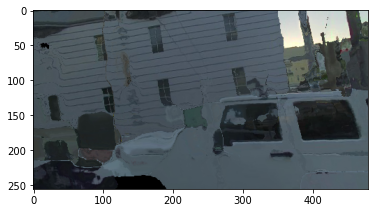

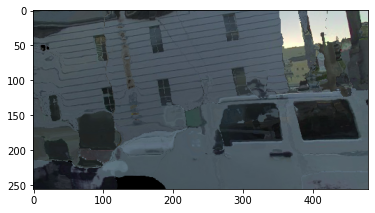

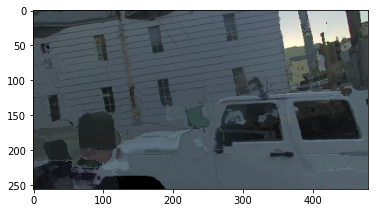

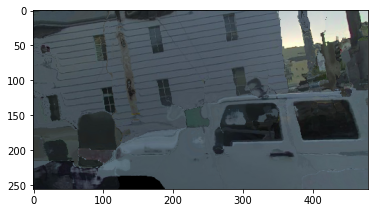

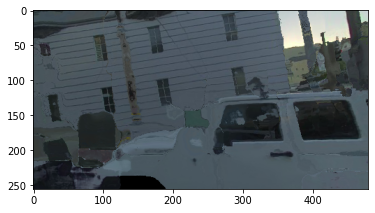

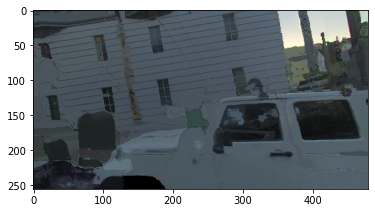

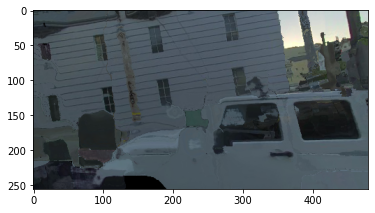

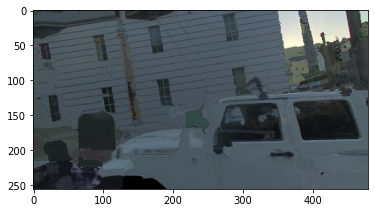

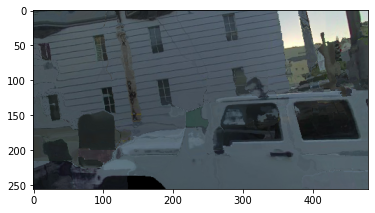

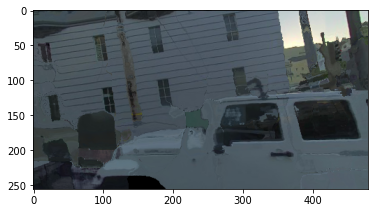

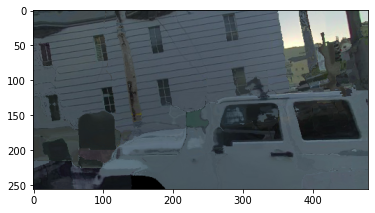

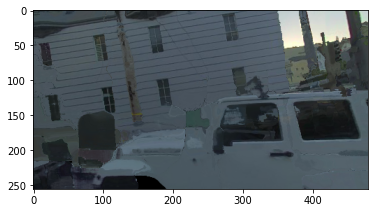

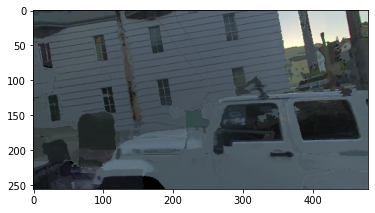

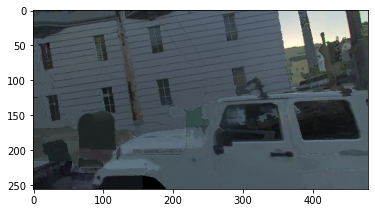

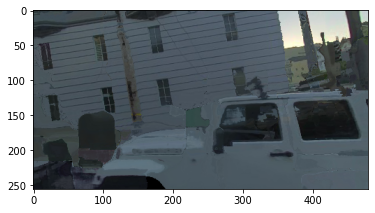

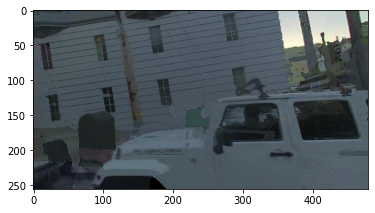

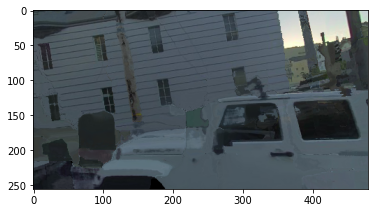

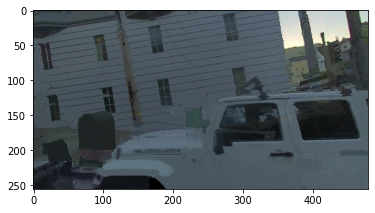

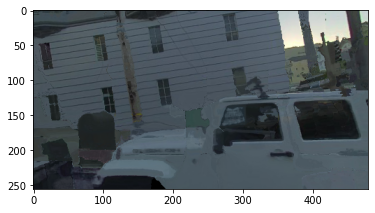

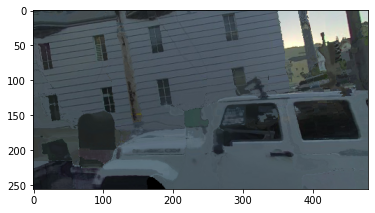

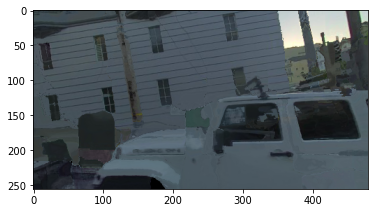

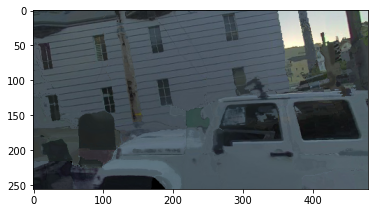

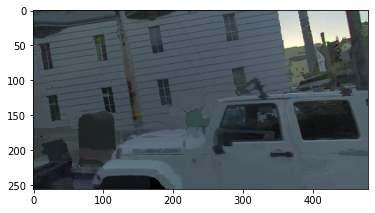

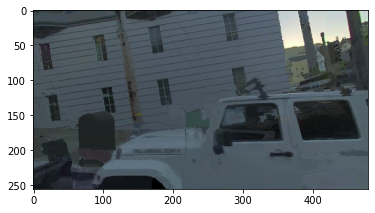

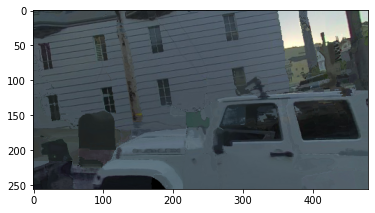

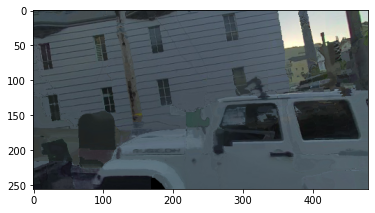

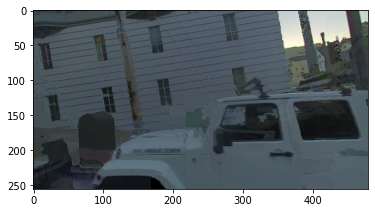

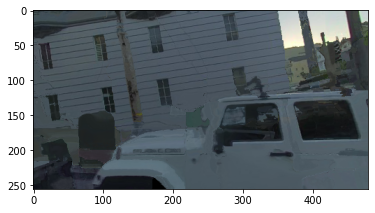

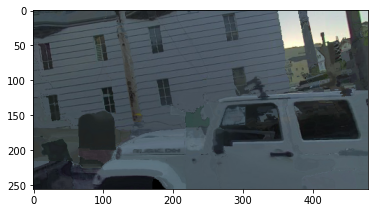

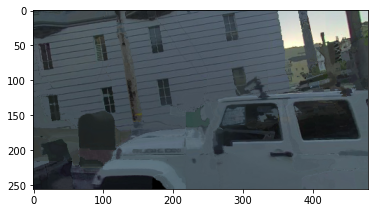

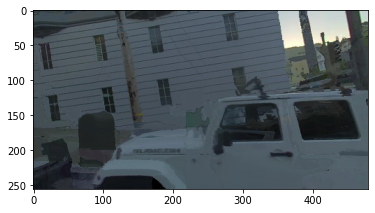

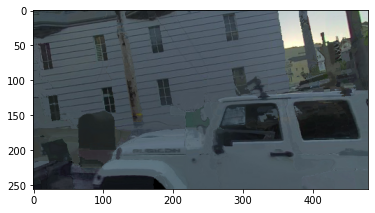

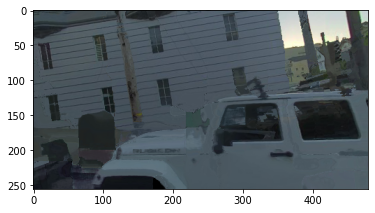

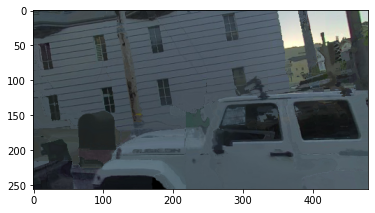

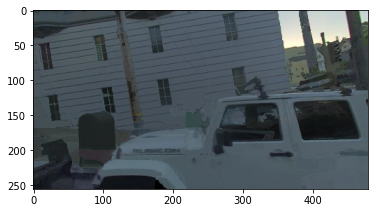

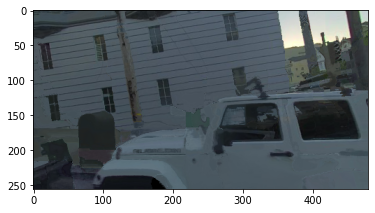

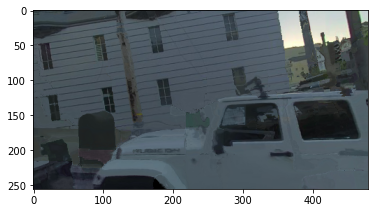

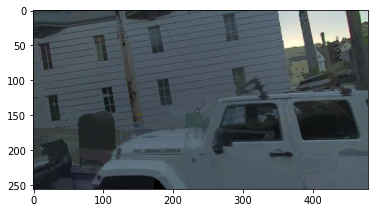

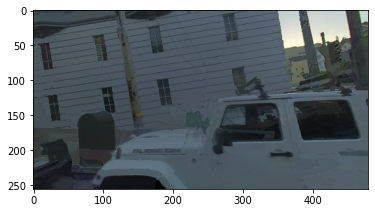

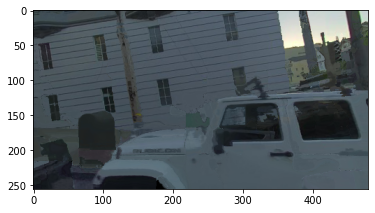

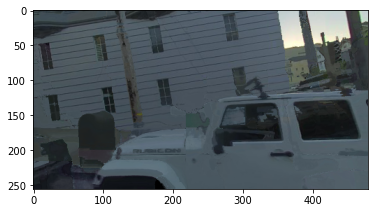

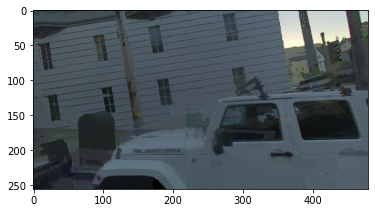

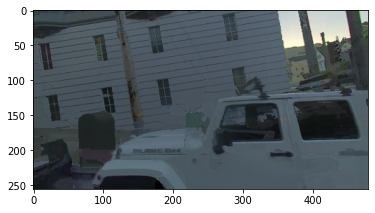

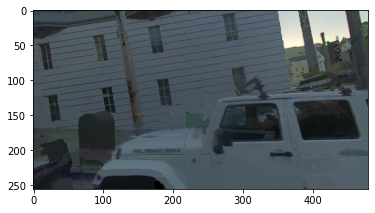

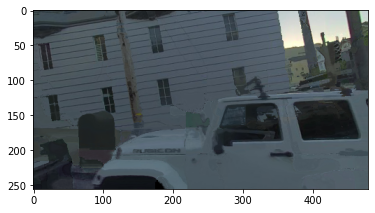

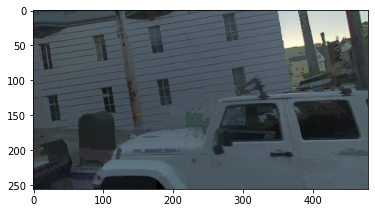

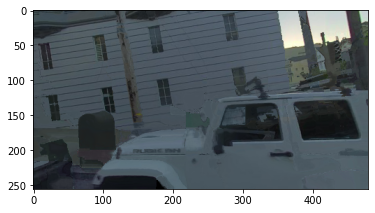

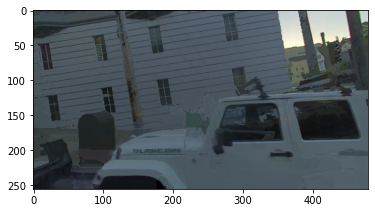

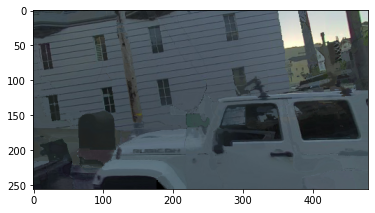

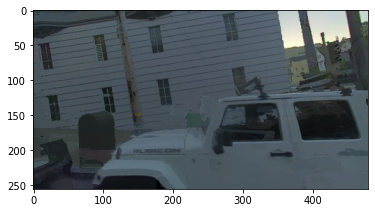

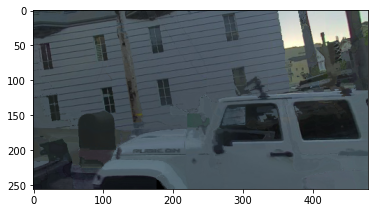

In [ ]:
i = 0
list_iter = []
list_psnr = []
list_loss = []
def closure():
    
    global i, list_iter, list_psnr, list_loss
    
    net_input = net_input_saved
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)

    out_trans = transformer(img_var1.type(torch.FloatTensor),out.type(torch.FloatTensor)).type(dtype)
   
    total_loss = mse(out_trans, img_var2)
    total_loss.backward()
        
    if PLOT and i % show_every == 0:
        print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
        
        out_np = torch_to_np(out_trans)
        list_iter.append(i)
        list_psnr.append(compare_psnr(img_np2,out_np))
        list_loss.append(total_loss.item())
        plt.imshow(out_np.transpose(1,2,0))
        plt.show()
        #plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

p = get_params(net)
optimize(p, closure, LR, num_iter)

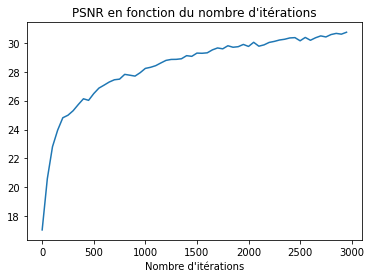

In [ ]:
plt.figure()
plt.plot(list_iter,list_psnr,linestyle='-')
plt.title("PSNR en fonction du nombre d'itérations")
plt.xlabel("Nombre d'itérations")
plt.show()

In [ ]:
out = net(net_input)
out_np = torch_to_np(out)

In [ ]:
out_np.shape

(2, 256, 480)

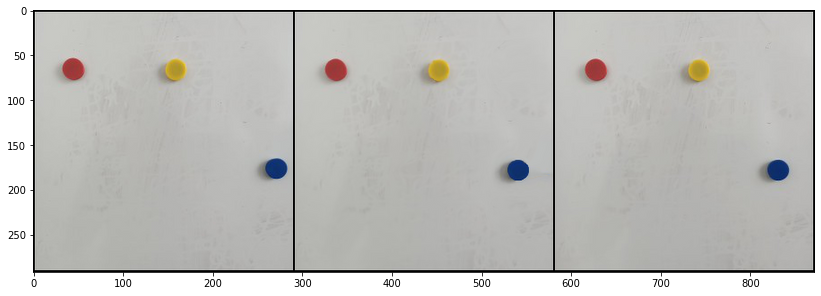

In [ ]:
plot_image_grid([img_np1, out_np, img_np2], 3,11);

# Affichage du champ de mouvement

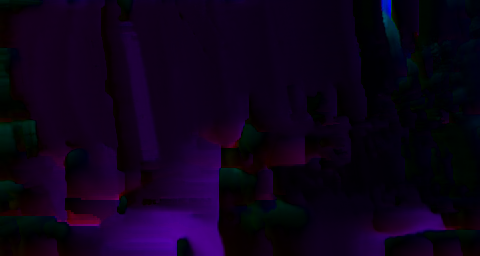

In [ ]:
hsv = np.zeros(img_np1.transpose(1,2,0).shape, dtype=np.uint8)
hsv[..., 1] = 255

mag, ang = cv2.cartToPolar(-out_np[0,...], out_np[1, ...])
hsv[..., 0] = ang * 180 / np.pi / 2
hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
cv2_imshow(bgr)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
im = Image.fromarray(bgr.astype(np.uint8))
im.save('optical_flow.jpg')

# Résultat du recalage

In [ ]:
out_trans = transformer(img_var1.type(torch.FloatTensor),out.type(torch.FloatTensor)).type(dtype)
out_np = torch_to_np(out_trans)
t = out_np.transpose(1,2,0)*255
im = Image.fromarray(t.astype(np.uint8))
im.save('res_recalage.jpg')

# Différence entre image source et résultat du recalage

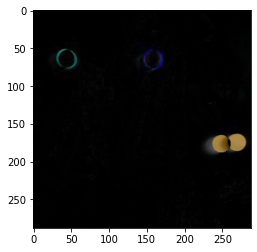

In [ ]:
out_trans = transformer(img_var1.type(torch.FloatTensor),out.type(torch.FloatTensor)).type(dtype)
out_np = torch_to_np(out_trans)
t = abs(img_np1 - out_np)
plt.imshow(t.transpose(1,2,0))

# Différence entre image cible et résultat du recalage

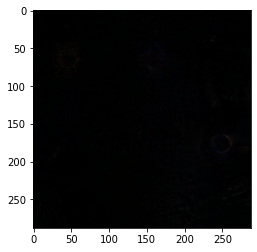

In [ ]:
diff = abs(img_np2 - out_np)
plt.imshow(diff.transpose(1,2,0))

# Affichage du champ de mouvement par une carte de chaleur

In [ ]:
v_np = torch_to_np(out)

In [ ]:
u = v_np[0]
v = v_np[1]

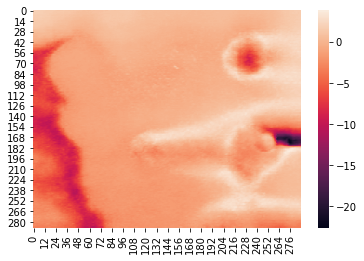

In [ ]:
#norme = np.sqrt(u**2 + v**2)
ax = sns.heatmap(u)
plt.show()

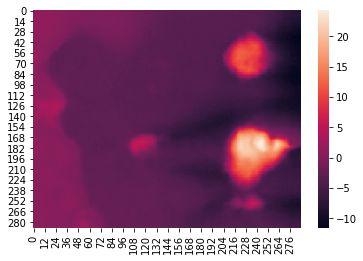

In [ ]:
ax = sns.heatmap(v)
plt.show()

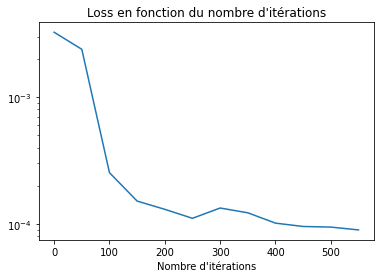

In [ ]:
plt.figure()
plt.semilogy(list_iter,list_loss,linestyle='-')
plt.title("Loss en fonction du nombre d'itérations")
plt.xlabel("Nombre d'itérations")
plt.show()